In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
data_dir = './data/state_reconstruct/reconstruction_data/'
figures_dir = './figures/'
_t = np.linspace(0, 100, 4001)

In [3]:
mean_squared_errors = {}
mean_absolute_errors = {}

stim_types = ['base','lw','lt','lwlt','burst']

colors = {
    'base':'maroon',
    'lw':'orangered',
    'lt':'darkgreen',
    'lwlt':'teal',
    'burst':'indigo'
}

for stim_type in stim_types:
    mean_squared_errors[stim_type] = np.load(f'{data_dir}mean_squared_error_{stim_type}.npy')
    mean_absolute_errors[stim_type] = np.load(f'{data_dir}mean_absolute_error_{stim_type}.npy')

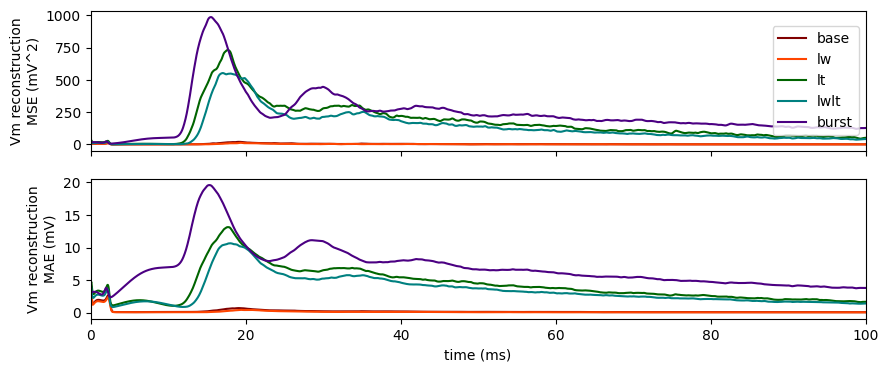

In [4]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,4))

for stim_type in stim_types:
    
    axes[0].plot(_t, mean_squared_errors[stim_type][0,:], c = colors[stim_type])
    axes[1].plot(_t, mean_absolute_errors[stim_type][0,:], c = colors[stim_type])


axes[0].set_ylabel('Vm reconstruction\nMSE (mV^2)')
axes[1].set_ylabel('Vm reconstruction\nMAE (mV)')
axes[-1].set_xlabel('time (ms)')

axes[0].legend(stim_types, loc='right')

axes[-1].set_xlim(0,100)

plt.show()

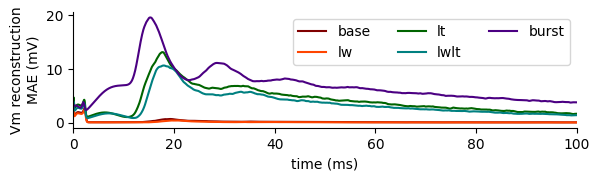

In [15]:
plt.figure(figsize=(6.5,1.5))
for stim_type in stim_types:
    
    plt.plot(_t, mean_absolute_errors[stim_type][0,:], c = colors[stim_type])
    
plt.ylabel('Vm reconstruction\nMAE (mV)')
plt.xlabel('time (ms)')


plt.legend(stim_types, loc='upper right', ncols=3)
plt.xlim(0,100)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig(f'{figures_dir}reconstruction_errors.svg', format='svg')
#plt.savefig(f'{figures_dir}reconstruction_errors.png', format='png', dpi=300)

plt.show()